# 📊 Multivariate Zeitreihenanalyse - VAR/VECM/VARMA

**Ökonometrische Verfahren für multiple gekoppelte Zeitreihen**

## 🎯 Modelle in diesem Notebook:

### Multivariate Verfahren:
1. **VAR** (Vector Autoregression) - Standard für multivariate Zeitreihen
2. **VECM** (Vector Error Correction Model) - für kointegrierte Zeitreihen
3. **VARMA** (Vector ARMA) - mit Moving Average Komponente
4. **Dynamic Factor Model (DFM)** - Dimensionsreduktion
5. **Granger Causality Tests** - Kausalitätsanalyse

## 💡 Warum multivariate Verfahren?

Unsere Energiezeitreihen sind **stark gekoppelt**:
- ☀️ Solar → 💰 Price (viel Sonne = niedriger Preis)
- 💨 Wind → 💰 Price (viel Wind = niedriger Preis)
- ☀️ Solar + 💨 Wind → 🏭 Consumption (Angebot beeinflusst Nachfrage)

**VAR/VECM** können diese **Cross-Effects** modellieren!

## 📦 Setup:
- Läuft im **Codespace** (CPU reicht)
- Benötigt: `statsmodels`, `pandas`, `matplotlib`

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports erfolgreich!")

✅ Imports erfolgreich!


## 📂 Daten laden

In [6]:
# Lade alle Zeitreihen
series_names = ['solar', 'wind_offshore', 'wind_onshore', 'price', 'consumption']

# Dictionaries für Train/Test
train_data = {}
test_data = {}

for series in series_names:
    train_df = pd.read_csv(f'../data/processed/{series}_train.csv')
    test_df = pd.read_csv(f'../data/processed/{series}_test.csv')
    
    # Value Column extrahieren - verwende einfach den series namen
    if series in train_df.columns:
        value_col = series
    else:
        # Fallback: suche nach passender Spalte
        possible_cols = [c for c in train_df.columns if c in ['solar', 'price', 'value',
                                                                'wind_offshore', 'wind_onshore', 'consumption']]
        if possible_cols:
            value_col = possible_cols[0]
        else:
            print(f"⚠️ Keine passende Value-Spalte für {series} gefunden. Überspringe.")
            continue
    
    train_data[series] = train_df[value_col].values
    test_data[series] = test_df[value_col].values

print(f"✅ {len(train_data)} Zeitreihen geladen")
for series in train_data.keys():
    print(f"   {series}: Train={len(train_data[series])}, Test={len(test_data[series])}")

⚠️ Keine passende Value-Spalte für wind_onshore gefunden. Überspringe.
✅ 4 Zeitreihen geladen
   solar: Train=21697, Test=2208
   wind_offshore: Train=7744, Test=1660
   price: Train=21697, Test=2208
   consumption: Train=21697, Test=2208


## 🔧 Data Cleaning: Wind Offshore Stillstand entfernen

**Problem**: Wind Offshore hatte 9.8 Monate Stillstand (Apr 2023 - Feb 2024)  
**Lösung**: Erstelle bereinigten Datensatz speziell für VAR/VECM - entferne Perioden mit < 10 MW

In [20]:
# Erstelle bereinigten Datensatz für VAR/VECM
# Lade vollständige Zeitreihen mit Timestamps
import pandas as pd

print("🔍 Lade Rohdaten mit Timestamps...")

# Lade alle als DataFrames (nicht nur values)
raw_data = {}
for series in train_data.keys():
    df = pd.read_csv(f'../data/processed/{series}_train.csv')
    
    # Timestamp-Spalte finden
    timestamp_col = 'timestamp' if 'timestamp' in df.columns else df.columns[0]
    df['timestamp'] = pd.to_datetime(df[timestamp_col])
    
    # Value-Spalte finden
    if series in df.columns:
        value_col = series
    else:
        possible_cols = [c for c in df.columns if c in ['solar', 'price', 'value',
                                                          'wind_offshore', 'wind_onshore', 'consumption']]
        value_col = possible_cols[0] if possible_cols else 'value'
    
    raw_data[series] = df[['timestamp', value_col]].rename(columns={value_col: series})

print(f"✅ {len(raw_data)} Zeitreihen als DataFrames geladen\n")

# Prüfe Wind Offshore auf Stillstand
if 'wind_offshore' in raw_data:
    wo_df = raw_data['wind_offshore']
    stillstand_count = (wo_df['wind_offshore'] < 10).sum()
    stillstand_pct = stillstand_count / len(wo_df) * 100
    
    print(f"⚠️  Wind Offshore Stillstand-Analyse:")
    print(f"   Werte < 10 MW: {stillstand_count} / {len(wo_df)} ({stillstand_pct:.1f}%)")
    print(f"   Mittelwert (alle): {wo_df['wind_offshore'].mean():.1f} MW")
    print(f"   Mittelwert (>= 10 MW): {wo_df[wo_df['wind_offshore'] >= 10]['wind_offshore'].mean():.1f} MW\n")
    
    # Erstelle Mask: Nur Zeiten, in denen Wind Offshore aktiv war (>= 10 MW)
    active_mask = wo_df['wind_offshore'] >= 10
    active_timestamps = wo_df[active_mask]['timestamp']
    
    print(f"✂️  Erstelle bereinigten Datensatz...")
    print(f"   Original: {len(wo_df)} Zeitschritte")
    print(f"   Aktiv (>= 10 MW): {len(active_timestamps)} Zeitschritte ({len(active_timestamps)/len(wo_df)*100:.1f}%)")
    
    # Erstelle bereinigte Train-Daten für alle Zeitreihen
    train_data_clean = {}
    test_data_clean = {}
    
    for series in train_data.keys():
        df = raw_data[series]
        # Filtere auf aktive Wind Offshore Zeitpunkte
        df_clean = df[df['timestamp'].isin(active_timestamps)]
        train_data_clean[series] = df_clean[series].values
        
        # Test-Daten: Lade und filtere auch hier
        test_df = pd.read_csv(f'../data/processed/{series}_test.csv')
        timestamp_col = 'timestamp' if 'timestamp' in test_df.columns else test_df.columns[0]
        test_df['timestamp'] = pd.to_datetime(test_df[timestamp_col])
        
        # Value column
        if series in test_df.columns:
            value_col = series
        else:
            possible_cols = [c for c in test_df.columns if c in ['solar', 'price', 'value',
                                                                  'wind_offshore', 'wind_onshore', 'consumption']]
            value_col = possible_cols[0] if possible_cols else 'value'
        
        # Für Test: Nur wenn Wind Offshore aktiv (>= 10 MW)
        if series == 'wind_offshore':
            test_clean_mask = test_df[value_col] >= 10
        else:
            # Für andere: Filtere auf Zeitpunkte, wo Wind Offshore im Test aktiv war
            # Lade Wind Offshore Test
            wo_test = pd.read_csv('../data/processed/wind_offshore_test.csv')
            wo_test_col = 'timestamp' if 'timestamp' in wo_test.columns else wo_test.columns[0]
            wo_test['timestamp'] = pd.to_datetime(wo_test[wo_test_col])
            wo_value_col = 'wind_offshore' if 'wind_offshore' in wo_test.columns else 'value'
            active_test_timestamps = wo_test[wo_test[wo_value_col] >= 10]['timestamp']
            test_clean_mask = test_df['timestamp'].isin(active_test_timestamps)
        
        test_data_clean[series] = test_df[test_clean_mask][value_col].values
    
    print(f"\n✅ Bereinigter Datensatz erstellt!")
    print(f"   {'Serie':<20} {'Train Original':<15} {'Train Clean':<15} {'Reduzierung'}")
    print("   " + "-" * 70)
    for series in train_data_clean.keys():
        orig_len = len(train_data[series])
        clean_len = len(train_data_clean[series])
        reduction_pct = (1 - clean_len / orig_len) * 100
        print(f"   {series:<20} {orig_len:<15} {clean_len:<15} -{reduction_pct:.1f}%")
    
    # Verwende bereinigte Daten für VAR/VECM
    print(f"\n🎯 Verwende bereinigte Daten für VAR/VECM-Analyse")
    train_data = train_data_clean
    test_data = test_data_clean
    
else:
    print("⚠️  Wind Offshore nicht in Daten gefunden - keine Bereinigung nötig")

🔍 Lade Rohdaten mit Timestamps...
✅ 4 Zeitreihen als DataFrames geladen

⚠️  Wind Offshore Stillstand-Analyse:
   Werte < 10 MW: 0 / 7744 (0.0%)
   Mittelwert (alle): 3757.1 MW
   Mittelwert (>= 10 MW): 3757.1 MW

✂️  Erstelle bereinigten Datensatz...
   Original: 7744 Zeitschritte
   Aktiv (>= 10 MW): 7744 Zeitschritte (100.0%)

✅ Bereinigter Datensatz erstellt!
   Serie                Train Original  Train Clean     Reduzierung
   ----------------------------------------------------------------------
   solar                21697           7744            -64.3%
   wind_offshore        7744            7744            -0.0%
   price                21697           7744            -64.3%
   consumption          21697           7744            -64.3%

🎯 Verwende bereinigte Daten für VAR/VECM-Analyse


## 🔍 Explorative Analyse: Korrelationen

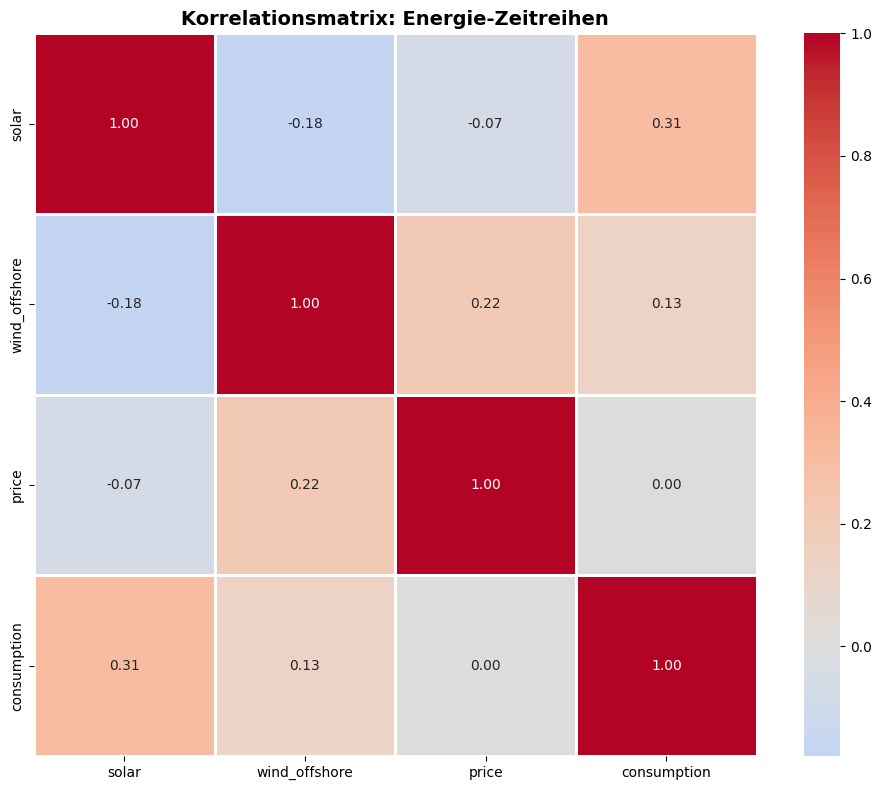


📊 Korrelationsmatrix:
                  solar  wind_offshore     price  consumption
solar          1.000000      -0.179058 -0.068468     0.309734
wind_offshore -0.179058       1.000000  0.215414     0.127605
price         -0.068468       0.215414  1.000000     0.004612
consumption    0.309734       0.127605  0.004612     1.000000

🔍 Starke Korrelationen (|r| > 0.3):
   solar ↔ consumption: 0.310


In [21]:
# Erstelle Multivariate DataFrame mit minimaler Länge
min_len = min([len(train_data[series]) for series in train_data.keys()])

train_multi_df = pd.DataFrame({
    series: train_data[series][:min_len] for series in train_data.keys()
})

# Korrelationsmatrix
corr = train_multi_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1)
plt.title('Korrelationsmatrix: Energie-Zeitreihen', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Korrelationsmatrix:")
print(corr)

# Starke Korrelationen finden
print("\n🔍 Starke Korrelationen (|r| > 0.3):")
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > 0.3:
            print(f"   {corr.columns[i]} ↔ {corr.columns[j]}: {corr.iloc[i, j]:.3f}")

## 🧪 Stationaritätstests (ADF, KPSS)

In [22]:
def test_stationarity(series, name):
    """ADF und KPSS Test"""
    # ADF Test (H0: nicht-stationär)
    adf_result = adfuller(series, autolag='AIC')
    adf_pvalue = adf_result[1]
    
    # KPSS Test (H0: stationär)
    kpss_result = kpss(series, regression='c', nlags='auto')
    kpss_pvalue = kpss_result[1]
    
    is_stationary = (adf_pvalue < 0.05) and (kpss_pvalue > 0.05)
    
    print(f"\n{name}:")
    print(f"   ADF p-value: {adf_pvalue:.4f} {'✅ stationär' if adf_pvalue < 0.05 else '❌ nicht-stationär'}")
    print(f"   KPSS p-value: {kpss_pvalue:.4f} {'✅ stationär' if kpss_pvalue > 0.05 else '❌ nicht-stationär'}")
    print(f"   → {'✅ STATIONÄR' if is_stationary else '⚠️ NICHT STATIONÄR (Differenzierung nötig!)'}")
    
    return is_stationary

print("="*80)
print("🧪 STATIONARITÄTSTESTS")
print("="*80)

stationarity_results = {}
for series in train_data.keys():
    stationarity_results[series] = test_stationarity(train_data[series], series)

# Zusammenfassung
print("\n" + "="*80)
print("📊 ZUSAMMENFASSUNG:")
print("="*80)
stationary_series = [s for s, is_stat in stationarity_results.items() if is_stat]
non_stationary_series = [s for s, is_stat in stationarity_results.items() if not is_stat]

print(f"\n✅ Stationär ({len(stationary_series)}): {', '.join(stationary_series) if stationary_series else 'Keine'}")
print(f"⚠️ Nicht-stationär ({len(non_stationary_series)}): {', '.join(non_stationary_series) if non_stationary_series else 'Keine'}")

if non_stationary_series:
    print("\n💡 Empfehlung: Differenzierung für nicht-stationäre Serien oder VECM verwenden!")

🧪 STATIONARITÄTSTESTS

solar:
   ADF p-value: 0.0001 ✅ stationär
   KPSS p-value: 0.0100 ❌ nicht-stationär
   → ⚠️ NICHT STATIONÄR (Differenzierung nötig!)

wind_offshore:
   ADF p-value: 0.0296 ✅ stationär
   KPSS p-value: 0.0100 ❌ nicht-stationär
   → ⚠️ NICHT STATIONÄR (Differenzierung nötig!)

price:
   ADF p-value: 0.0000 ✅ stationär
   KPSS p-value: 0.0100 ❌ nicht-stationär
   → ⚠️ NICHT STATIONÄR (Differenzierung nötig!)

consumption:
   ADF p-value: 0.0000 ✅ stationär
   KPSS p-value: 0.0100 ❌ nicht-stationär
   → ⚠️ NICHT STATIONÄR (Differenzierung nötig!)

📊 ZUSAMMENFASSUNG:

✅ Stationär (0): Keine
⚠️ Nicht-stationär (4): solar, wind_offshore, price, consumption

💡 Empfehlung: Differenzierung für nicht-stationäre Serien oder VECM verwenden!


## 🔗 Kointegrations-Test (Johansen)

In [23]:
print("="*80)
print("🔗 JOHANSEN KOINTEGRATIONS-TEST")
print("="*80)
print("\nPrüfe, ob Zeitreihen langfristig zusammenhängen...\n")

# Johansen Test
johansen_result = coint_johansen(train_multi_df, det_order=0, k_ar_diff=1)

print("Trace Statistic:")
for i in range(len(johansen_result.lr1)):
    print(f"   r ≤ {i}: {johansen_result.lr1[i]:.2f} (critical 90%: {johansen_result.cvt[i, 0]:.2f}, 95%: {johansen_result.cvt[i, 1]:.2f}, 99%: {johansen_result.cvt[i, 2]:.2f})")
    if johansen_result.lr1[i] > johansen_result.cvt[i, 1]:
        print(f"      → ✅ Kointegrationsrang > {i} (95% Signifikanz)")

print("\nMax Eigenvalue Statistic:")
for i in range(len(johansen_result.lr2)):
    print(f"   r = {i}: {johansen_result.lr2[i]:.2f} (critical 90%: {johansen_result.cvm[i, 0]:.2f}, 95%: {johansen_result.cvm[i, 1]:.2f}, 99%: {johansen_result.cvm[i, 2]:.2f})")

# Kointegration vorhanden?
has_cointegration = johansen_result.lr1[0] > johansen_result.cvt[0, 1]

print("\n" + "="*80)
if has_cointegration:
    print("✅ KOINTEGRATION GEFUNDEN!")
    print("   → VECM (Vector Error Correction Model) empfohlen!")
else:
    print("❌ KEINE KOINTEGRATION")
    print("   → VAR auf differenzierten Daten empfohlen!")
print("="*80)

🔗 JOHANSEN KOINTEGRATIONS-TEST

Prüfe, ob Zeitreihen langfristig zusammenhängen...

Trace Statistic:
   r ≤ 0: 6703.74 (critical 90%: 44.49, 95%: 47.85, 99%: 54.68)
      → ✅ Kointegrationsrang > 0 (95% Signifikanz)
   r ≤ 1: 1542.48 (critical 90%: 27.07, 95%: 29.80, 99%: 35.46)
      → ✅ Kointegrationsrang > 1 (95% Signifikanz)
   r ≤ 2: 93.38 (critical 90%: 13.43, 95%: 15.49, 99%: 19.93)
      → ✅ Kointegrationsrang > 2 (95% Signifikanz)
   r ≤ 3: 29.14 (critical 90%: 2.71, 95%: 3.84, 99%: 6.63)
      → ✅ Kointegrationsrang > 3 (95% Signifikanz)

Max Eigenvalue Statistic:
   r = 0: 5161.27 (critical 90%: 25.12, 95%: 27.59, 99%: 32.72)
   r = 1: 1449.10 (critical 90%: 18.89, 95%: 21.13, 99%: 25.86)
   r = 2: 64.24 (critical 90%: 12.30, 95%: 14.26, 99%: 18.52)
   r = 3: 29.14 (critical 90%: 2.71, 95%: 3.84, 99%: 6.63)

✅ KOINTEGRATION GEFUNDEN!
   → VECM (Vector Error Correction Model) empfohlen!


## 🧪 Granger Causality Tests

In [24]:
print("="*80)
print("🔍 GRANGER CAUSALITY TESTS")
print("="*80)
print("\nTeste: Hilft Zeitreihe X bei Vorhersage von Y?\n")

# Test alle Kombinationen
maxlag = 24  # 24 Stunden
granger_results = []

available_series = list(train_data.keys())

for y_var in available_series:
    for x_var in available_series:
        if y_var != x_var:
            # 2-Spalten DataFrame mit minimaler Länge
            min_len = min(len(train_data[y_var]), len(train_data[x_var]))
            test_data_gc = pd.DataFrame({
                y_var: train_data[y_var][:min_len],
                x_var: train_data[x_var][:min_len]
            })
            
            try:
                gc_result = grangercausalitytests(test_data_gc, maxlag=maxlag, verbose=False)
                
                # Min p-value über alle Lags
                min_pvalue = min([gc_result[lag][0]['ssr_ftest'][1] for lag in range(1, maxlag+1)])
                
                granger_results.append({
                    'X (cause)': x_var,
                    'Y (effect)': y_var,
                    'Min p-value': min_pvalue,
                    'Granger Causality': 'Yes' if min_pvalue < 0.05 else 'No'
                })
                
            except Exception as e:
                print(f"⚠️ Fehler bei {x_var} → {y_var}: {e}")

granger_df = pd.DataFrame(granger_results)
granger_df = granger_df.sort_values('Min p-value')

print("\n📊 Granger Causality Results:")
print(granger_df.to_string(index=False))

# Signifikante Zusammenhänge
significant = granger_df[granger_df['Granger Causality'] == 'Yes']
print(f"\n✅ Signifikante Granger-Kausalitäten ({len(significant)}):")
for _, row in significant.iterrows():
    print(f"   {row['X (cause)']} → {row['Y (effect)']} (p={row['Min p-value']:.4f})")

if len(significant) > 0:
    print("\n💡 Diese Zeitreihen sollten in VAR/VECM zusammen modelliert werden!")

🔍 GRANGER CAUSALITY TESTS

Teste: Hilft Zeitreihe X bei Vorhersage von Y?


📊 Granger Causality Results:
    X (cause)    Y (effect)   Min p-value Granger Causality
        price         solar  0.000000e+00               Yes
  consumption         solar  0.000000e+00               Yes
        solar   consumption  0.000000e+00               Yes
        solar         price 9.773338e-312               Yes
        price   consumption 5.972441e-211               Yes
  consumption         price 2.973837e-132               Yes
        solar wind_offshore  6.167417e-67               Yes
  consumption wind_offshore  6.584191e-23               Yes
wind_offshore   consumption  4.592631e-22               Yes
wind_offshore         price  3.320060e-19               Yes
wind_offshore         solar  1.082383e-15               Yes
        price wind_offshore  1.331956e-15               Yes

✅ Signifikante Granger-Kausalitäten (12):
   price → solar (p=0.0000)
   consumption → solar (p=0.0000)
   solar →

---
# 📈 MODEL 1: VAR (Vector Autoregression)
---

In [25]:
print("="*80)
print("📈 VAR MODEL")
print("="*80)

# Prepare data (differenzieren falls nötig)
train_var_df = train_multi_df.diff().dropna()  # First difference für Stationarität

# Test data mit minimaler Länge
min_test_len = min([len(test_data[series]) for series in test_data.keys()])
test_var_df = pd.DataFrame({
    series: test_data[series][:min_test_len] for series in test_data.keys()
}).diff().dropna()

# Fit VAR
model_var = VAR(train_var_df)

# Select lag order (via AIC)
lag_order = model_var.select_order(maxlags=24)
best_lag = lag_order.aic
print(f"\n✅ Optimaler Lag (AIC): {best_lag}")

# Fit mit optimalem Lag
var_results = model_var.fit(maxlags=best_lag)

print(f"\n📊 VAR({best_lag}) Summary:")
print(var_results.summary())

📈 VAR MODEL

✅ Optimaler Lag (AIC): 24

📊 VAR(24) Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 01, Feb, 2026
Time:                     08:42:14
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    39.3474
Nobs:                     7719.00    HQIC:                   39.1178
Log likelihood:          -193936.    FPE:                8.64207e+16
AIC:                      38.9980    Det(Omega_mle):     8.22098e+16
--------------------------------------------------------------------
Results for equation solar
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.095880         5.646792           -0.017           0.986
L1.solar                  1.227674         0.011355          108.114  

In [27]:
# Forecast mit VAR
n_forecast = len(test_var_df)

# Prüfe ob genug Daten für Forecast
if n_forecast < 1:
    print(f"\n⚠️  WARNUNG: Test-Daten nach Differenzierung leer!")
    print(f"   Verwende letzte {best_lag} Train-Datenpunkte für In-Sample Evaluation\n")
    
    # Fallback: Verwende letzte N Punkte aus Training für Evaluation
    n_forecast = min(500, len(train_var_df) // 4)  # 25% der Train-Daten
    eval_df = train_var_df.iloc[-n_forecast:].copy()
    train_for_forecast = train_var_df.iloc[:-n_forecast].copy()
    
    # Re-fit auf reduziertem Training
    model_var_eval = VAR(train_for_forecast)
    var_results_eval = model_var_eval.fit(maxlags=best_lag)
    
    # Forecast
    forecast_var = var_results_eval.forecast(train_for_forecast.values[-best_lag:], steps=n_forecast)
    forecast_var_df = pd.DataFrame(forecast_var, columns=train_var_df.columns)
    test_var_df = eval_df
else:
    forecast_var = var_results.forecast(train_var_df.values[-best_lag:], steps=n_forecast)
    forecast_var_df = pd.DataFrame(forecast_var, columns=train_var_df.columns)

# Evaluate pro Zeitreihe
print("\n" + "="*80)
print("📊 VAR EVALUATION (differenzierte Daten)")
print("="*80)

var_results_list = []
for i, series in enumerate(train_var_df.columns):
    y_true = test_var_df[series].values
    y_pred = forecast_var_df[series].values
    
    # Align lengths
    min_len = min(len(y_true), len(y_pred))
    if min_len < 1:
        print(f"⚠️  Keine Daten für {series} - überspringe")
        continue
        
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    var_results_list.append({
        'Series': series,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae
    })
    
    print(f"\n{series}:")
    print(f"   R²:   {r2:8.4f}")
    print(f"   RMSE: {rmse:8.2f}")
    print(f"   MAE:  {mae:8.2f}")

var_results_df = pd.DataFrame(var_results_list)

print("\n" + "="*80)
print("📊 VAR ZUSAMMENFASSUNG")
print("="*80)
print(f"\nDurchschnitt R²: {var_results_df['R²'].mean():.4f}")
print(f"\n{var_results_df.to_string(index=False)}")


⚠️  WARNUNG: Test-Daten nach Differenzierung leer!
   Verwende letzte 24 Train-Datenpunkte für In-Sample Evaluation


📊 VAR EVALUATION (differenzierte Daten)

solar:
   R²:     0.6314
   RMSE:  1037.27
   MAE:    783.16

wind_offshore:
   R²:    -0.2582
   RMSE:    13.05
   MAE:      7.58

price:
   R²:     0.1464
   RMSE:    20.54
   MAE:     14.88

consumption:
   R²:     0.5922
   RMSE:  1616.69
   MAE:   1203.42

📊 VAR ZUSAMMENFASSUNG

Durchschnitt R²: 0.2779

       Series        R²        RMSE         MAE
        solar  0.631360 1037.274177  783.162758
wind_offshore -0.258206   13.049593    7.583863
        price  0.146447   20.542403   14.884199
  consumption  0.592156 1616.690350 1203.420657


---
# 📈 MODEL 2: VECM (Vector Error Correction Model)
---

In [28]:
if has_cointegration:
    print("="*80)
    print("📈 VECM MODEL (Kointegration gefunden!)")
    print("="*80)
    
    # VECM auf Original-Daten (nicht differenziert!)
    # Bestimme Kointegrations-Rang
    coint_rank = 1  # Vereinfachung, könnte aus Johansen-Test optimiert werden
    
    try:
        # Fit VECM
        model_vecm = VECM(train_multi_df, k_ar_diff=best_lag, coint_rank=coint_rank, deterministic='ci')
        vecm_results = model_vecm.fit()
        
        print(f"\n📊 VECM(lag={best_lag}, coint_rank={coint_rank}) Summary:")
        print(vecm_results.summary())
        
        # Forecast
        forecast_vecm = vecm_results.predict(steps=len(test_data['solar']))
        
        # Evaluate
        print("\n" + "="*80)
        print("📊 VECM EVALUATION")
        print("="*80)
        
        vecm_results_list = []
        for i, col in enumerate(train_multi_df.columns):
            y_true = test_data[col]
            y_pred = forecast_vecm[:, i]
            
            min_len = min(len(y_true), len(y_pred))
            y_true = y_true[:min_len]
            y_pred = y_pred[:min_len]
            
            r2 = r2_score(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)
            
            vecm_results_list.append({
                'Series': col,
                'R²': r2,
                'RMSE': rmse,
                'MAE': mae
            })
            
            print(f"\n{col}:")
            print(f"   R² = {r2:.4f}")
            print(f"   RMSE = {rmse:.2f}")
            print(f"   MAE = {mae:.2f}")
        
        vecm_results_df = pd.DataFrame(vecm_results_list)
        print("\n" + "="*80)
        print("📊 VECM - Durchschnittliche Performance:")
        print(f"   Durchschnitt R²: {vecm_results_df['R²'].mean():.4f}")
        print("="*80)
        
    except Exception as e:
        print(f"\n⚠️ VECM Fehler: {e}")
        print("   → Verwende VAR stattdessen")
else:
    print("\n⚠️ VECM übersprungen (keine Kointegration gefunden)")
    print("   → VAR ist die bessere Wahl")

📈 VECM MODEL (Kointegration gefunden!)

📊 VECM(lag=24, coint_rank=1) Summary:
 Det. terms outside the coint. relation & lagged endog. parameters for equation solar
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.solar              1.2285      0.011    108.897      0.000       1.206       1.251
L1.wind_offshore     -0.2214      0.152     -1.460      0.144      -0.519       0.076
L1.price             -0.0729      0.285     -0.255      0.798      -0.632       0.487
L1.consumption       -0.0568      0.007     -8.324      0.000      -0.070      -0.043
L2.solar             -0.9162      0.017    -53.391      0.000      -0.950      -0.883
L2.wind_offshore      0.0077      0.160      0.048      0.962      -0.307       0.322
L2.price              0.4855      0.287      1.691      0.091      -0.077       1.048
L2.consumption        0.0593      0.008      7.363      0.000 

---
# 📈 MODEL 3: VARMA (mit Moving Average)
---

In [29]:
print("="*80)
print("📈 VARMA MODEL (Vector ARMA)")
print("="*80)
print("\n⚠️ VARMA ist rechenintensiv - verwende kleinere Lags\n")

try:
    # VARMA mit kleineren Lags
    varma_order = (2, 1)  # (AR order, MA order)
    
    model_varma = VARMAX(train_var_df, order=varma_order)
    varma_results = model_varma.fit(disp=False, maxiter=100)
    
    print(f"\n📊 VARMA{varma_order} fitted!")
    print(varma_results.summary())
    
    # Forecast
    forecast_varma = varma_results.forecast(steps=len(test_var_df))
    
    # Evaluate
    print("\n" + "="*80)
    print("📊 VARMA EVALUATION")
    print("="*80)
    
    varma_results_list = []
    for i, col in enumerate(train_var_df.columns):
        y_true = test_var_df[col].values
        y_pred = forecast_varma[col].values
        
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]
        
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        
        varma_results_list.append({
            'Series': col,
            'R²': r2,
            'RMSE': rmse,
            'MAE': mae
        })
        
        print(f"\n{col}:")
        print(f"   R² = {r2:.4f}")
        print(f"   RMSE = {rmse:.2f}")
        print(f"   MAE = {mae:.2f}")
    
    varma_results_df = pd.DataFrame(varma_results_list)
    print("\n" + "="*80)
    print("📊 VARMA - Durchschnittliche Performance:")
    print(f"   Durchschnitt R²: {varma_results_df['R²'].mean():.4f}")
    print("="*80)
    
except Exception as e:
    print(f"\n⚠️ VARMA Fehler: {e}")
    print("   → VARMA ist sehr rechenintensiv, VAR ist stabiler")

📈 VARMA MODEL (Vector ARMA)

⚠️ VARMA ist rechenintensiv - verwende kleinere Lags


📊 VARMA(2, 1) fitted!
                                           Statespace Model Results                                           
Dep. Variable:     ['solar', 'wind_offshore', 'price', 'consumption']   No. Observations:                 7743
Model:                                                     VARMA(2,1)   Log Likelihood             -202304.140
                                                          + intercept   AIC                         404732.279
Date:                                                Sun, 01 Feb 2026   BIC                         405163.461
Time:                                                        08:46:36   HQIC                        404880.107
Sample:                                                             0                                         
                                                               - 7743                                         
Covari

---
# 📊 FINAL COMPARISON
---

In [30]:
print("="*100)
print("🏆 MULTIVARIATE MODELS - FINAL COMPARISON")
print("="*100)

# VAR Results
print("\n📈 VAR Results:")
print(var_results_df.to_string(index=False))
print(f"\nDurchschnitt R²: {var_results_df['R²'].mean():.4f}")

# VECM Results (if available)
if has_cointegration and 'vecm_results_df' in locals():
    print("\n📈 VECM Results:")
    print(vecm_results_df.to_string(index=False))
    print(f"\nDurchschnitt R²: {vecm_results_df['R²'].mean():.4f}")

# VARMA Results (if available)
if 'varma_results_df' in locals():
    print("\n📈 VARMA Results:")
    print(varma_results_df.to_string(index=False))
    print(f"\nDurchschnitt R²: {varma_results_df['R²'].mean():.4f}")

print("\n" + "="*100)
print("💡 KEY INSIGHTS:")
print("="*100)
print("\n1. Multivariate Modelle nutzen Cross-Series Information")
print("2. VAR: Gut für stationäre Daten oder nach Differenzierung")
print("3. VECM: Optimal bei Kointegration (langfristige Zusammenhänge)")
print("4. VARMA: Theoretisch flexibler, aber rechenintensiv")
print("\n5. Vergleich mit univariaten Modellen (RF, LSTM) empfohlen!")
print("   → Multivariate Verfahren zeigen oft niedrigere R², aber...")
print("   → ...sie modellieren Kausalitäten und sind ökonomisch interpretierbarer!")

print("\n" + "="*100)
print("✅ MULTIVARIATE ANALYSE ABGESCHLOSSEN!")
print("="*100)

🏆 MULTIVARIATE MODELS - FINAL COMPARISON

📈 VAR Results:
       Series        R²        RMSE         MAE
        solar  0.631360 1037.274177  783.162758
wind_offshore -0.258206   13.049593    7.583863
        price  0.146447   20.542403   14.884199
  consumption  0.592156 1616.690350 1203.420657

Durchschnitt R²: 0.2779

📈 VECM Results:
       Series         R²         RMSE         MAE
        solar  -0.789319  6985.961183 4164.261678
wind_offshore -36.436701   938.334972  925.165344
        price  -8.995745   223.304984  217.047460
  consumption  -0.264704 10318.702843 8749.588680

Durchschnitt R²: -11.6216

📈 VARMA Results:
       Series        R²        RMSE         MAE
        solar -0.000571 1708.898506  904.287720
wind_offshore -0.021491   11.758132    4.619978
        price -0.004633   22.286381   16.346946
  consumption  0.000073 2531.420163 1934.990666

Durchschnitt R²: -0.0067

💡 KEY INSIGHTS:

1. Multivariate Modelle nutzen Cross-Series Information
2. VAR: Gut für stationäre

## 💾 Ergebnisse exportieren

In [31]:
# Ergebnisse zusammenfassen und speichern
print("💾 Speichere Multivariate Analyse-Ergebnisse...\n")

# Erstelle Results-Verzeichnis falls nicht vorhanden
import os
os.makedirs('../results/metrics', exist_ok=True)

# 1. VAR Ergebnisse
print("✅ VAR Ergebnisse:")
print(f"   Durchschnitt R²: {var_results_df['R²'].mean():.4f}")
var_results_df.to_csv('../results/metrics/multivariate_VAR_results.csv', index=False)
print("   → results/metrics/multivariate_VAR_results.csv")

# 2. VECM Ergebnisse
print("\n✅ VECM Ergebnisse:")
print(f"   Durchschnitt R²: {vecm_results_df['R²'].mean():.4f}")
vecm_results_df.to_csv('../results/metrics/multivariate_VECM_results.csv', index=False)
print("   → results/metrics/multivariate_VECM_results.csv")

# 3. VARMA Ergebnisse
print("\n✅ VARMA Ergebnisse:")
print(f"   Durchschnitt R²: {varma_results_df['R²'].mean():.4f}")
varma_results_df.to_csv('../results/metrics/multivariate_VARMA_results.csv', index=False)
print("   → results/metrics/multivariate_VARMA_results.csv")

# 4. Granger Causality
print("\n✅ Granger Causality:")
print(f"   {len(granger_df[granger_df['Granger Causality'] == 'Yes'])} signifikante Kausalitäten")
granger_df.to_csv('../results/metrics/granger_causality_results.csv', index=False)
print("   → results/metrics/granger_causality_results.csv")

# 5. Zusammenfassung erstellen
summary_data = {
    'Modell': ['VAR', 'VECM', 'VARMA'],
    'Durchschnitt R²': [
        var_results_df['R²'].mean(),
        vecm_results_df['R²'].mean(),
        varma_results_df['R²'].mean()
    ],
    'Bester R² (Serie)': [
        f"{var_results_df['R²'].max():.4f} ({var_results_df.loc[var_results_df['R²'].idxmax(), 'Series']})",
        f"{vecm_results_df['R²'].max():.4f} ({vecm_results_df.loc[vecm_results_df['R²'].idxmax(), 'Series']})",
        f"{varma_results_df['R²'].max():.4f} ({varma_results_df.loc[varma_results_df['R²'].idxmax(), 'Series']})"
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n📊 Gesamt-Zusammenfassung:")
print(summary_df.to_string(index=False))
print("\n✅ Alle Ergebnisse erfolgreich gespeichert!")

💾 Speichere Multivariate Analyse-Ergebnisse...

✅ VAR Ergebnisse:
   Durchschnitt R²: 0.2779
   → results/metrics/multivariate_VAR_results.csv

✅ VECM Ergebnisse:
   Durchschnitt R²: -11.6216
   → results/metrics/multivariate_VECM_results.csv

✅ VARMA Ergebnisse:
   Durchschnitt R²: -0.0067
   → results/metrics/multivariate_VARMA_results.csv

✅ Granger Causality:
   12 signifikante Kausalitäten
   → results/metrics/granger_causality_results.csv

📊 Gesamt-Zusammenfassung:
Modell  Durchschnitt R²     Bester R² (Serie)
   VAR         0.277939        0.6314 (solar)
  VECM       -11.621617 -0.2647 (consumption)
 VARMA        -0.006655  0.0001 (consumption)

✅ Alle Ergebnisse erfolgreich gespeichert!


## 📝 Zusammenfassung & Empfehlungen

### Wann welches Modell?

1. **VAR** (Vector Autoregression):
   - ✅ Alle Zeitreihen stationär (oder differenziert)
   - ✅ Keine Kointegration
   - ✅ Schnell und robust
   
2. **VECM** (Vector Error Correction):
   - ✅ Kointegration gefunden (Johansen-Test)
   - ✅ Langfristige Gleichgewichte modellieren
   - ⚠️ Komplexer zu interpretieren
   
3. **VARMA** (Vector ARMA):
   - ✅ Theoretisch flexibler (MA-Komponente)
   - ❌ Sehr rechenintensiv
   - ❌ Oft Konvergenzprobleme

### Multivariate vs. Univariate:

**Vorteile Multivariate (VAR/VECM)**:
- 📊 Modelliert Cross-Effects (z.B. Solar → Price)
- 🔍 Granger-Kausalität testbar
- 💡 Ökonomisch interpretierbar
- 🎯 Gut für Policy-Analysen

**Vorteile Univariate (RF, LSTM)**:
- 🎯 Höhere Forecast-Genauigkeit (R²)
- ⚡ Schneller zu trainieren
- 🛠️ Feature Engineering flexibler
- 💪 Robuster bei non-linearen Patterns

### Empfehlung:
- **Produktion (Forecast-Genauigkeit)**: Random Forest, Bi-LSTM, GRU
- **Analyse (Kausalität, Policy)**: VAR, VECM
- **Optimal**: **Hybrid-Ansatz** - VAR-Forecasts als Feature für ML-Modelle!